### Background
In this notebook we select the best compounds from the latest round of synthesis + the best compounds from the original series 4 to seed chemsampler and generate new molecules. Those will be scored against malaria predictive models as well as other relevant aspects (admet...)

In [ ]:
import os
import pandas as pd

DATAPATH = "../data"

In [ ]:
filename = "ersilia_nov22.csv"
df = pd.read_csv(os.path.join(DATAPATH, filename))
df = df[df["activity"]<1]
smi = df["smiles"].tolist()

In [ ]:
from chemsampler import ChemSampler

cs = ChemSampler(samplers_list= ["ChemblSampler", "PubChemSampler", "StonedSampler", "FasmifraSampler", "SmallWorldSampler", "MollibSampler"])
results = cs.sample(smi, num_samples=10000)

In [ ]:
for k,v in results.items():
    print(k)
    print(len(v))

In [ ]:
import csv
with open(os.path.join(DATAPATH, "sampled_{}.csv".format(filename.split(".")[0])), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["smiles"])
    for i in range(len(results)):
        key = list(results.keys(s))[i]
        # writer.writerow([key]) #it will write a single list, if want to retrieve by sampler, uncomment this
        for j in range(len(results[key])):
            writer.writerow([results[key][j]])

# New compounds analysis

In [5]:
#for all sampled smiles
from rdkit import Chem
import pandas as pd
import os

DATAPATH = "../data"

sampled_file = "sampled_ersilia_nov22.csv"
df = pd.read_csv(os.path.join(DATAPATH, sampled_file))

In [6]:
#filter out any molecules that could be in the original list
original = pd.read_csv(os.path.join(DATAPATH, "osm_all.csv"))
or_mols = [Chem.MolFromSmiles(s) for s in original["smiles"]]
original["inchikey"] = [Chem.MolToInchiKey(m) for m in or_mols]
df_mols = [Chem.MolFromSmiles(s) for s in df["smiles"]]
df["inchikey"] = [Chem.MolToInchiKey(m) for m in df_mols]
print(len(df))
merged = pd.merge(df, original, on='inchikey', how='inner')
df = df[~df.index.isin(merged.index)]
print(len(df))

328
276


In [7]:
#find the Maximum common substructure in the set of tested smiles
import rdkit.Chem.rdFMCS as rdFMCS

intsmi = pd.read_csv(os.path.join(DATAPATH, "ersilia_nov22.csv"))

mols = [Chem.MolFromSmiles(smi) for smi in intsmi["smiles"]]
mcs = rdFMCS.FindMCS(mols)
smarts1 = mcs.smartsString
#a bit more flexibility has been allowed in the right hand substituent
smarts2 = "F[#6](F)-[#8]-c1ccc(cc1)-c1nnc2cncc(-[#8]-[#6]-[*])n12"

#test the different smarts to identify best
smiles_list = ["OCN1N=NC(C2=CC=C(OCC3=CC=C(OCC4=CC=CC(C(F)(F)F)=C4)C=C3)C=C2)=N1",
    "FC(F)OC1=CC=C(C2=NN(CC3=CC=CC(C(F)(F)F)=C3)C=N2)C=C1",
    "C1=2C=NC=C(N1C(=NN=2)C3=CC=C(C=C3)OC(F)F)OCCC4C=5C=C(F)C(=CC=5C4)F",
    "O(C)C(C=1C=CC(=CC=1)C(F)F)COC=2N3C(C=NC=2)=NN=C3C=4C=CC=CC=4",
    "C=NC(C1=CC=C(C=C1)OC(F)F)OCOC2=CN=CC=3N2C(=NN=3)C=4C=CC(OC(F)F)=CC=4",
    "CC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(CCC3=CC=CC(=C3)C(F)(F)F)N12"]

pattern = Chem.MolFromSmarts(smarts2)
for idx,smiles in enumerate(smiles_list):
    m = Chem.MolFromSmiles(smiles)
    print("Structure {}: pattern found {}".format(idx+1,m.HasSubstructMatch(pattern)))

Structure 1: pattern found False
Structure 2: pattern found False
Structure 3: pattern found True
Structure 4: pattern found False
Structure 5: pattern found True
Structure 6: pattern found False


In [8]:
patterns = [smarts1, smarts2]

for i,p in enumerate(patterns):
    pmol = Chem.MolFromSmarts(p)
    substr = []
    for smi in df["smiles"]:
        m = Chem.MolFromSmiles(smi)
        if m.HasSubstructMatch(pmol):
            substr += [1]
        else:
            substr += [0]
    df["substr{}".format(i)] = substr

In [10]:
df[(df["substr0"]==1)&(df["substr1"]==1)]

,smiles,inchikey,substr0,substr1
52,N=1N=C2C=NC=C(N2C=1C=3C=CC(OC(F)F)=CC=3)OC4C5=...,LXSADGDQWLMHSV-UHFFFAOYSA-N,1,1
54,C(C(F)F)(OC)COC=1N2C(=NN=C2C=NC=1)C3=CC=C(C=C3...,WEVCDMSJGPNANZ-UHFFFAOYSA-N,1,1
55,FC(C1=CC(COC2=CN=CC3=NN=C(N32)C4=CC=C(OC(F)F)C...,GFOVKZFJBMGDTF-UHFFFAOYSA-N,1,1
56,O(C1=CN=CC2=NN=C(N12)C3=CC=C(C=C3)OC(F)F)CCC=C...,VERBAXAWDNZRTI-UHFFFAOYSA-N,1,1
59,FC(F)(F)N1C=CC=C(COC2=CN=CC=3N2C(C4=CC=C(C=C4)...,LLDZDMJPPAIFTR-UHFFFAOYSA-N,1,1
...,...,...,...,...
320,COC(COc1cncc2nnc(-c3ccc(OC(F)F)cc3)n12)c1ccc(F...,PNNXRAKBUGUVQC-UHFFFAOYSA-N,1,1
322,FC(F)Oc1ccc(-c2nnc3cncc(OCc4ccccc4C(F)(F)F)n23...,JZQWOBLPBIKWTG-UHFFFAOYSA-N,1,1
323,FC(F)Oc1ccc(-c2nnc3cncc(OC4CCOCC4)n23)cc1,AGPGQQYNCLEMPA-UHFFFAOYSA-N,1,1
324,FC(F)Oc1ccc(-c2nnc3cncc(OCC4CC4c4ccc(OC(F)F)cc...,SHBWMHWMDXNYNL-UHFFFAOYSA-N,1,1


In [11]:
# Predictions on the sampled molecules using ZairaChem models
preds_1 = pd.read_csv(os.path.join(DATAPATH, "zairachem_results", "{}_preds1.csv".format(sampled_file.split(".")[0])))
preds_25 = pd.read_csv(os.path.join(DATAPATH, "zairachem_results", "{}_preds25.csv".format(sampled_file.split(".")[0])))

df["act_1"] = preds_1["clf_ex1"]
df["act_2.5"] = preds_25["clf_ex1"]

In [12]:
# predictions from the MAIP model
maip = pd.read_csv(os.path.join(DATAPATH, "other_models", "{}_maip.csv".format(sampled_file.split(".")[0])))
df["maip"] = maip["model_score"]

In [13]:
# predictions from the ADMETLab2
admet = pd.read_csv(os.path.join(DATAPATH, "other_models", "{}_admetlab2.csv".format(sampled_file.split(".")[0])))
for c in admet.columns[1:]:
    df[c] = admet[c]

In [14]:
df.to_csv(os.path.join(DATAPATH, "sampled_ersilia_nov22_preds.csv"), index=False)

In [40]:
df = pd.read_csv(os.path.join(DATAPATH, "sampled_ersilia_nov22_preds.csv"))

df = df[df["substr1"]==1]
df = df[df["LogP"]<=3.5]
len(df)

58

In [41]:
df2 = df.sort_values(["act_1", "act_2.5", "maip"], ascending =False)

In [42]:
import mols2grid
mols2grid.display(df2, smiles_col="smiles")

MolGridWidget()

In [43]:
df3 = df2[df2["act_2.5"]>=0.5]

In [44]:
df4 = df3[df3["T12"]<0.5]
df4["eos_id"] = ["eosi_{}".format(i) for i in range(0,19)]
df4["act_2.5"] = df4["act_2.5"].round(2)
df4["act_1"] = df4["act_1"].round(2)

/tmp/ipykernel_23511/3583051640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["eos_id"] = ["eosi_{}".format(i) for i in range(0,19)]
/tmp/ipykernel_23511/3583051640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["act_2.5"] = df4["act_2.5"].round(2)
/tmp/ipykernel_23511/3583051640.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [52]:
mols2grid.display(df4, 
                  smiles_col="smiles",
                  n_cols=7,
                  subset = ["eos_id","img", "act_2.5", "LogP"],
                  )

MolGridWidget()

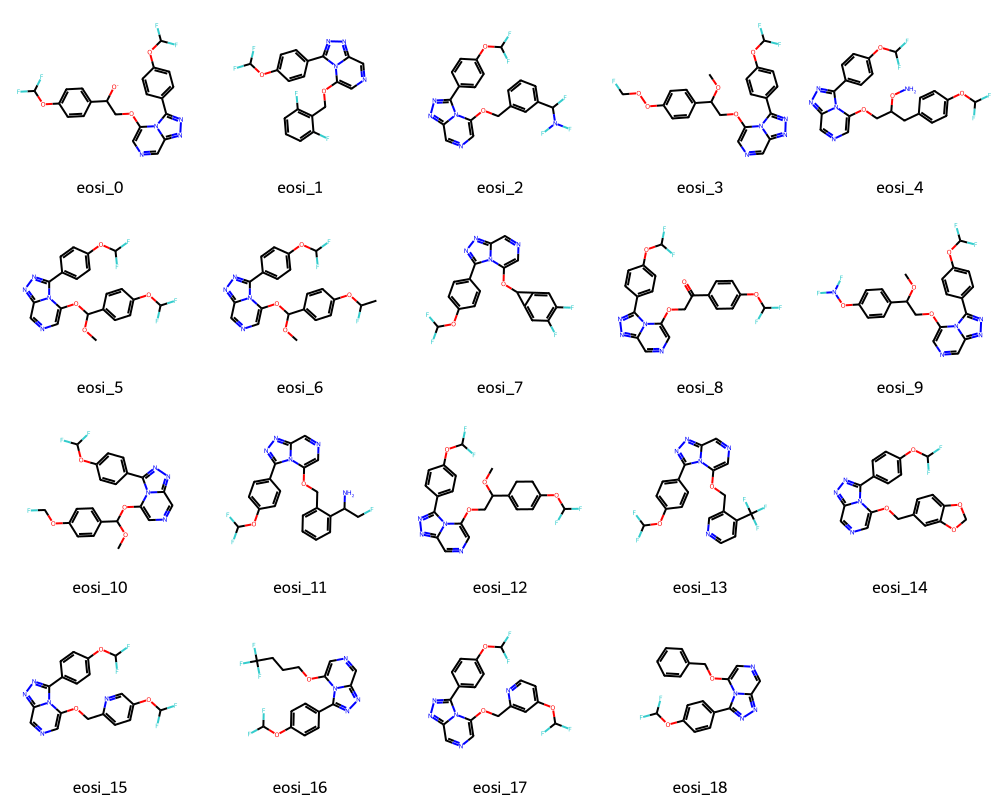

In [58]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(s) for s in df4["smiles"]]
img = Draw.MolsToGridImage(mols, molsPerRow=5, legends=df4["eos_id"].tolist())
img

In [61]:
df4.to_csv(os.path.join(DATAPATH, "sampled_ersilia_nov22_selection.csv"), index=False)

AttributeError: 'Image' object has no attribute 'size'